# Libraries 

In [35]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import randint
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from dmba import plotDecisionTree, classificationSummary, gainsChart, liftChart, backward_elimination, forward_selection, stepwise_selection
from dmba.metric import AIC_score


%matplotlib inline

# Question 1

# Import data
In this problem, I will develop a model to predict whether a given car gets high or low gas mileage based on the 
Auto data set.

Let's import and explore the data. 


In [36]:
# import data 
df = pd.read_csv('auto.csv')

# first 5 rows of the dataset 
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [37]:
# there are 397 rows and 9 columns in the data 
df.shape

(397, 9)

In [38]:
# overall information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.0+ KB


There are 397 rows and 9 columns in the data. 
Columns are: `mpg`, `cylinders`, `displacement`, `horsepower`, `weight`, `acceleration`, `year`, `origin`, and `name`
    
Dataset has 397 rows about different cars and their characteristics. Data only has null values in `horsepower` variable. 

## Null values
I want to deal with null values first, as null values might worsen the predictive performance of my models.

In [39]:
# check null rows 
null_rows = df['horsepower'].isnull()

# percentage of data for these null values 
percentage = round((len(df.loc[null_rows, :]) / len(df))*100, 1)

print(f"Null rows take only {percentage} percent of data.")

Null rows take only 1.3 percent of data.


There is only 1% of data that is null. It is safe to remove these rows. 

In [40]:
# remove na values 
df = df.dropna()

In [41]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## Binary variable

In [42]:
# create a binary variable called `mpg01`
df['mpg01'] = np.where(df['mpg'] > np.median(df['mpg']), 1, 0)


In [43]:
# check if it worked 
median_value = np.median(df['mpg'])
print(f'Median value is {median_value}')

df

Median value is 22.75


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0
...,...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl,1
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup,1
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage,1
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger,1


In [44]:
# check datatype of mpg01
df['mpg01'].info()

<class 'pandas.core.series.Series'>
Int64Index: 392 entries, 0 to 396
Series name: mpg01
Non-Null Count  Dtype
--------------  -----
392 non-null    int32
dtypes: int32(1)
memory usage: 4.6 KB



`mpg` column is not going to be used as I created a binary variable `mpg01` that contains a 1 if mpg contains a value above its median, and 0 if mpg contains a value below its median.

`name` column is also not going to be used as the name of the car doesn't determine the mpg, technical characteristics are the most important factors for predicting this variable. 

In [45]:
# drop `mpg` column 
df = df.drop('mpg', axis = 1).reset_index(drop = True)

# drop `name` column 
df = df.drop('name', axis = 1).reset_index(drop = True)

In [46]:
# convert weight column to float 
df['weight'] = df['weight'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     392 non-null    int64  
 1   displacement  392 non-null    float64
 2   horsepower    392 non-null    float64
 3   weight        392 non-null    float64
 4   acceleration  392 non-null    float64
 5   year          392 non-null    int64  
 6   origin        392 non-null    int64  
 7   mpg01         392 non-null    int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 23.1 KB


There is only 7 columns and no null values in the final dataset. Now I will explore cars and their characteristics using visualization.

# Data Exploration


## Mpg01 (target variable)

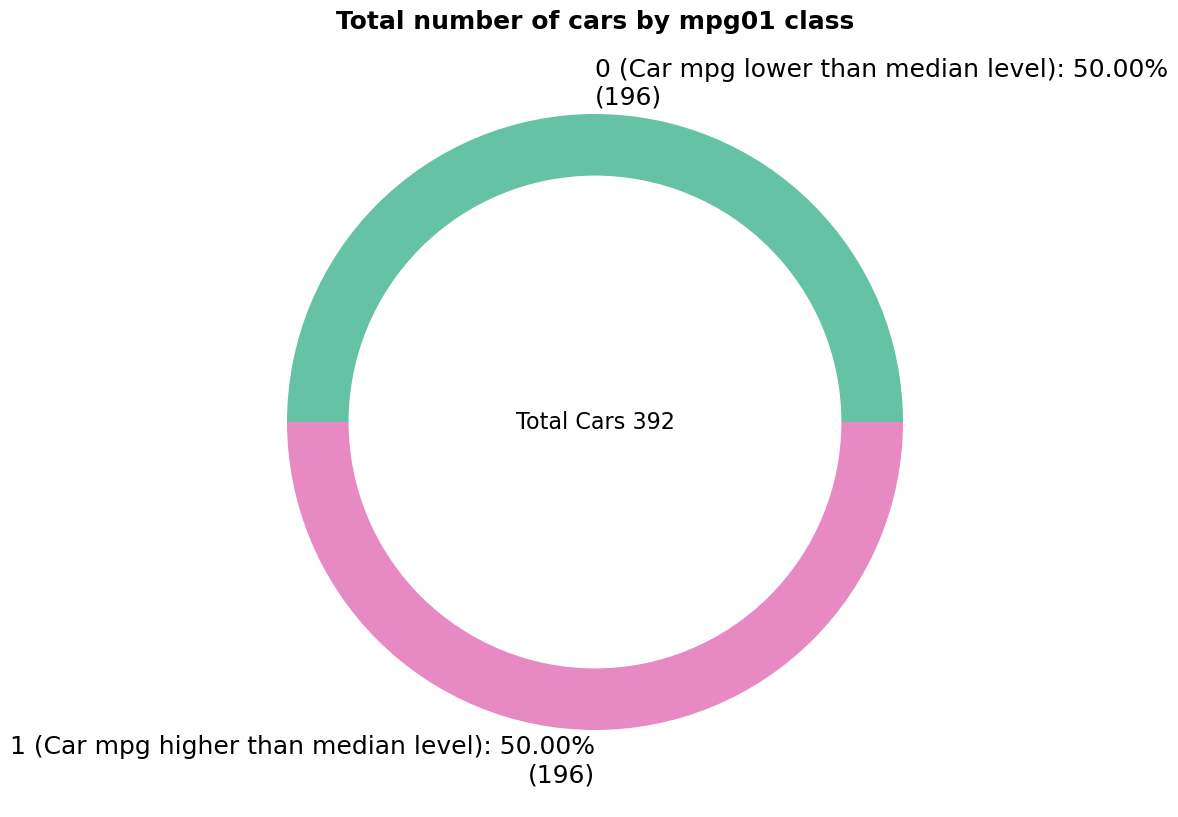

In [47]:
# pie chart that shows number  of car per target variable class 
## 1 - mpg higher than median mpg 
## 0 - mpg lower than median mpg 

plt.figure(figsize = (16, 10))

# class labels 
mpg1 = df[df['mpg01'] == 1].shape[0]
mpg0 = df[df['mpg01'] == 0].shape[0]

# total number
total = mpg1 + mpg0
# class percentages
mpg1_percent = (mpg1 / total) * 100 
mpg0_percent = (mpg0 / total) * 100 

# function to show labels and percentages of mpg01 class type
labels_with_info = [
    '0 (Car mpg lower than median level): {:.2f}%\n({})'.format(mpg0_percent, mpg0),
    '1 (Car mpg higher than median level): {:.2f}%\n({})'.format(mpg1_percent, mpg1)
]

# pie-chart plot 
plt.pie( 
    # values
    [mpg0, mpg1],
    # labels
    labels = labels_with_info,
    # text size 
    textprops = {'fontsize': 18}, 
    # color palette
    colors = ['#66c2a5', '#e78ac3'])

# circle at the center of pie to make it a donut 
circle = plt.Circle((0, 0), 0.80, fc = 'white')
plt.gcf().gca().add_artist(circle)

# add total in the center 
total = len(df['mpg01'])

# apply total number on pie chart 
plt.text(0, 0, f"Total Cars {total}", 
               ha='center', 
               va='center', fontsize=16)

# parameters
## title 
plt.title('Total number of cars by mpg01 class', fontweight = 'bold', fontsize = 18)

plt.show()



There is equal number of cars in 2 different classes. It means that there should be enough data for model to be trained, and I don't have to oversample the target variable, as it is not going to be dominated by data majority. But I will still need to check the numbers after data partition, as it might change. 

## Cylinders 

In [104]:
# values for bar chart 
cylinders = df.groupby('cylinders').size().reset_index()

# make columns 
cylinders.columns = ['cylinders', 'counts']

# change `cylinders` to categorical as it represents category
cylinders['cylinders'] = cylinders['cylinders'].astype(str)

# sort 
cylinders = cylinders.sort_values(by = 'counts', ascending = False)

# check 
cylinders

,cylinders,counts
1,4,199
4,8,103
3,6,83
0,3,4
2,5,3


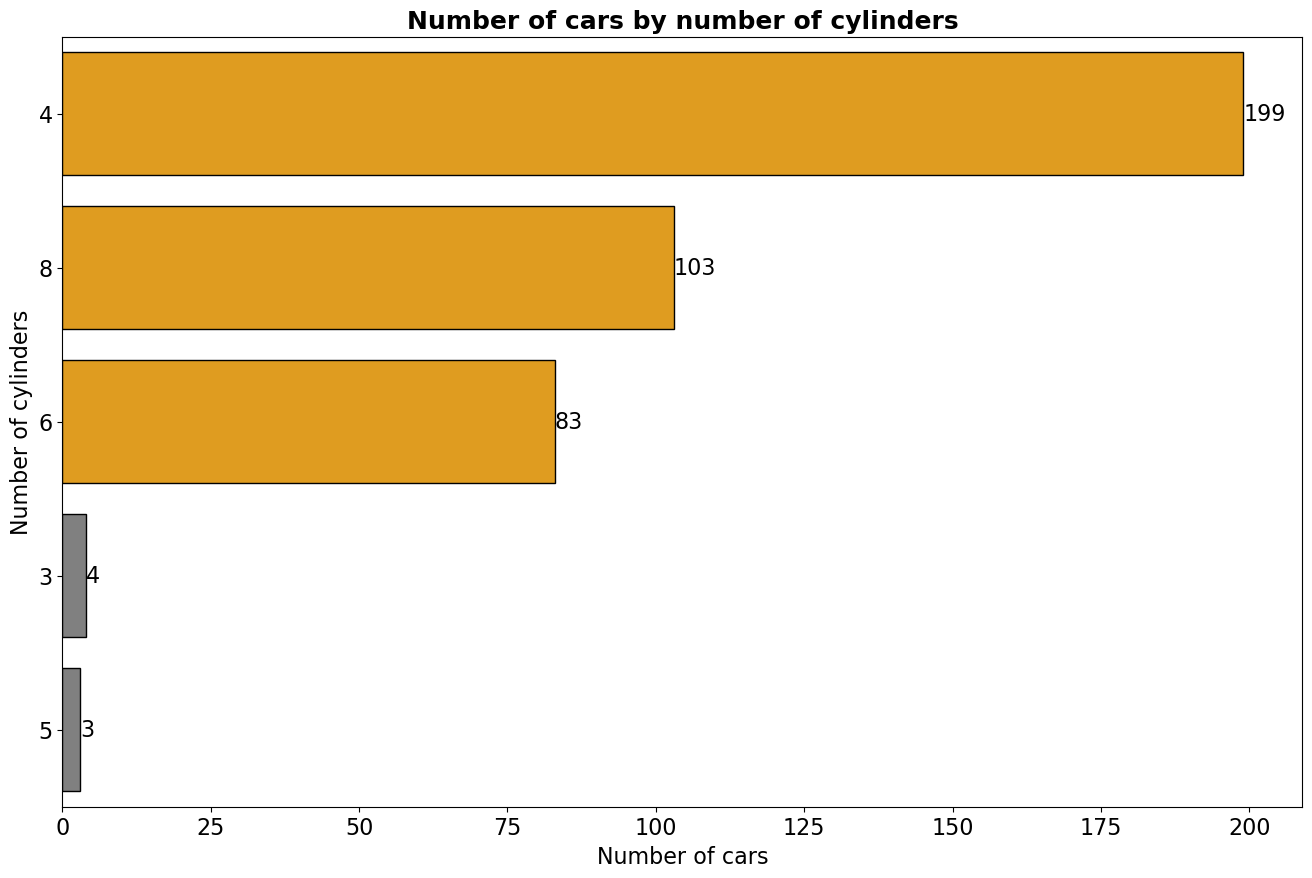

In [127]:
# bar plot for exploring cylinders variables 
## figure size 
plt.figure(figsize = (16, 10))


## colors 
colors = ['orange', 'orange', 'orange', 'grey', 'grey']
barplot = sns.barplot(data = cylinders, 
    # x 
    x = 'counts', 
    # y
    y = 'cylinders',  
    # edge colors of bars
    edgecolor = 'black', 
    # color palette 
    palette = colors, 
    # orientation
    orient = 'h'
    )



# parameters 
## title
plt.title('Number of cars by number of cylinders', fontweight = 'bold', fontsize = 18)

## x-label
plt.xlabel('Number of cars', fontsize = 16)
## x-ticks
plt.xticks(fontsize = 16)

## ylabel
plt.ylabel('Number of cylinders', fontsize = 16)
## y-ticks 
plt.yticks(fontsize = 16)


## annotations for labels
for i, (count, cyl) in enumerate(zip(cylinders['counts'], cylinders['cylinders'])):
    barplot.text(count, i,  # Position the text at the end of the bar
                 f'{count}', 
                 va='center', 
                 ha='left',  # Right align to avoid overlapping with the bar
                 color='black', 
                 fontsize=16)
    


plt.show()



In [ ]:
# relationships with target variable `mpg01` (boxplot)
def boxplot_relationship(data, target, feature):
    # graph size  
    plt.figure(figsize = (10, 6))

    # parameters 
    sns.boxplot(y = data[target], x = data[feature], orient = 'h', palette = "Set2")
    plt.title(f"Relationship between {feature} data and target {target} variable", fontweight = 'bold', fontsize = 18)
    plt.ylabel(f"{target}", fontsize = 15)
    plt.xlabel(f"{feature}", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    plt.show()

for column in df.columns:
    if column != 'mpg01' and df[column].dtype == 'float64' :  
        boxplot_relationship(df, 'mpg01', column)

In [ ]:
# relationships with target variable `mpg01` (boxplot)
def boxplot_relationship(data, target, feature):
    # graph size  
    plt.figure(figsize = (10, 6))

    # parameters 
    sns.boxplot(y = data[target], x = data[feature], orient = 'h', palette = "Set2")
    plt.title(f"Relationship between {feature} data and target {target} variable", fontweight = 'bold', fontsize = 18)
    plt.ylabel(f"{target}", fontsize = 15)
    plt.xlabel(f"{feature}", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    plt.show()

for column in df.columns:
    if column != 'mpg01' and df[column].dtype == 'int64' :  
        boxplot_relationship(df, 'mpg01', column)

In [ ]:
# relationships with target variable `mpg01` (scatterplot)
def scatterplot_relationship(data, target, feature):
    # graph size  
    plt.figure(figsize = (10, 6))

    # parameters 
    sns.scatterplot(y = data[feature], x = data[target])
    plt.title(f"Relationship between {feature} data and target {target} variable", fontweight = 'bold', fontsize = 18)
    plt.xlabel(f"{target}", fontsize = 15)
    plt.ylabel(f"{feature}", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

    plt.show()

for column in df.columns:
    if column != 'mpg01' and df[column].dtype == 'float64' :  
        scatterplot_relationship(df, 'mpg01', column)

`displacement`, `acceleration`, `horsepower`, `weight`, and `year` variables are important because they have clear relationship with `mpg01` variable. For example: 
 - Cars with mpg lower than median value tend to have a higher values of displacement than cars with mpg higher than median value. 
 
 
 - Cars with mpg lower than median value tend to have a higher horsepower levels than cars with mpg higher than median value.
 
 
 
 - Cars with mpg lower than median value are on average heavier than cars with mpg higher than median value. 
 
 
 
 - Cars with mpg higher than median value have higher acceleration than cars with mpg lower than median values.



 - Cars with mpg higher than median value on average are older than cars with mpg lower than median value. 
 
 
 When it comes to `Cylinders` and `Origin` variables, they don't provide any significant information numerically, as they represent categories and I might to convert these features to dummy variables. I need to check correlation between predictors to avoid multicollinearity.
 
P.S. I can't do dummy variables or any other data transformation, as such processes should be done after data is split into training and validation samples to avoid data leakage.

In [ ]:
# correlation between predictors and target variable (mpg01)
correlation = df.corr()

In [ ]:
# heatmap visualization
def heatmap(correlation_col):
    plt.figure(figsize = (20, 15))
    sns.heatmap(correlation, annot = True, cmap = 'coolwarm', fmt = '.2f', annot_kws = {'size': 15})
    plt.title('Correlation Matrix', fontweight = 'bold', fontsize = 18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()

heatmap(correlation)

In [ ]:
# VIF function to check for multicollinearity 
columns = df.columns.to_list()
x = df[columns]

vif_data = pd.DataFrame()
vif_data['feature'] = x.columns

vif_data["VIF"] = [variance_inflation_factor(x.values, i) 
                          for i in range(len(x.columns))]

print(vif_data)

1) `origin`, `weight` `horsepower`, `displacement`, and `cylinders` are variables that highly correlate with target `mpg01` variable. 

2) However, they are also highly correlated with each other, which might worsen the interpretation and explainability of the prediction algorithm. However, I figured out that by applying an `l2` regularization, I can still maintain my algorithm being explainable and interpretable even if it has multicollinearity. 

`l2` regularization for logistic regression makes coefficients of variables near to 0 and chooses the most significant variables, that's why this regularization will help with multicollinearity.

## c) Split the data into a training set and a test set using the seed 2401.
## d) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [ ]:
# split the data 
training = df.sample(frac = 0.6, random_state = 2401)
training.reset_index(drop = True, inplace = True)

validation = df.drop(training.index)
validation.reset_index(drop = True, inplace = True)




In [ ]:
# training data 
training.info()

In [ ]:
# validation data 
validation.info()

## Data distribution 
### training sample
An important factor that I need to explore is the data distribution, and whether particular variable is left-skewed, right-skewed or bell shaped. If any variable is skewed, I am going to convert it to approximately bell shape distribution using log transformation.

In [ ]:
# function that shows distribution through histograms for a particular data 
def distribution_graph(data):
    # distribution of data trough plot
    plt.figure(figsize=(20, 30))
    for i in list(enumerate(data.columns)):
        plt.subplot(6, 4, i[0]+1)
        sns.histplot(data = df[i[1]], kde=True)
    
    # skew score 
    skew = data.skew().sort_values(ascending = False)
    print(skew)

# apply the function
distribution_graph(training)

`Displacement`, `Horsepower`, and `weight` are highly skewed variables. `Origin`, and `Cylinders` columns can't be considered skewed even if they have skew scores 0.912 and 0.539 because they have `integer` datatypes and they represent categories. Now I will convert skewed data in the training data and then I will do the same in validation data. 

In any critical data tranformation, I will create draft training and validation variables in order avoid loosing progress if something goes wrong. 

In [ ]:
# draft variables 
# training
training_draft = training.copy()

# validation
validation_draft = validation.copy()

In [ ]:
# function to Logtransform `displacement` variable
def logTrans(df, feature):   
    # log transformation
    df_log = df.copy()
    df_log[feature] = np.log1p(df_log[feature])
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(df[feature], kde=True, color="red")
    
    plt.subplot(1,2,2)
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_log[feature], bins=20, kde=True , legend=False, color="blue")
    plt.xlabel(feature)
    
    plt.show()
    
    # Calculate skewness before and after transformation
    skew_before = df[feature].skew()
    skew_after = df_log[feature].skew()
    print(f"Skewness was {round(skew_before,2)} before & is {round(skew_after,2)} after Log transformation.")
    
    return df_log[feature]

training['displacement'] = logTrans(training, 'displacement')

In [ ]:
# apply the logtransformation function for `horsepower`
training['horsepower'] = logTrans(training, 'horsepower')

In [ ]:
# apply the logtransformation function for `weight`
training['weight'] = logTrans(training, 'weight')

### validation sample

In [ ]:
distribution_graph(validation)

In [ ]:
# apply the logtransformation function for `displacement`
validation['displacement'] = logTrans(validation, 'displacement')

In [ ]:
# apply the logtransformation function for `horsepower`
validation['horsepower'] = logTrans(validation, 'horsepower')

In [ ]:
# apply the logtransformation function for `weight`
validation['weight'] = logTrans(validation, 'weight')

I converted all right-skewed data both in training and validation draft samples using log transformation. Now I'm going to convert `origin` and `cylinders` variables to dummy. 

Before I start converting `origin` and `cylinders` variables to dummy, I want to check performance of my model at this step.

In [ ]:
# variable split function
def variable_split(y, data_train, data_validation): 
    train_x = data_train.drop(columns = [y])
    train_y = data_train[y]
    
    valid_x = data_validation.drop(columns = [y])
    valid_y = data_validation[y]
    
    return train_x, train_y, valid_x, valid_y 


train_x, train_y, valid_x, valid_y = variable_split('mpg01', training, validation)

In [ ]:
train_x

In [ ]:
valid_x

Variable split is done now. I want to ckeck performance of my model at this step where I converted some of the variables to the log form. 

In [ ]:
# fit a logistic regression
model = LogisticRegression(penalty = 'l2', 
                              C = 0.1, 
                              solver = 'liblinear')
model.fit(train_x, train_y)

print('intercept ', model.intercept_[0])
print(pd.DataFrame({'coeff': model.coef_[0]}, index=train_x.columns).transpose())
print()

In [ ]:
# function to check metrics 
def metrics(true_values, x, predictions, data, model): 
    # some statistics 
    print(f"{data} Accuracy: {accuracy_score(true_values, predictions):.4f}")
    print(f"{data} Precision: {precision_score(true_values, predictions):.4f}")
    print(f"{data} Recall: {recall_score(true_values, predictions):.4f}")
    print(f"{data} F1 Score: {f1_score(true_values, predictions):.4f}")
    
    # ROC curve 
    ROC = model.predict_proba(x)[:, 1]
    print(f"{data} ROC AUC: {roc_auc_score(true_values, ROC):.4f}")
    print()
    
    # AIC 
    print('AIC', AIC_score(true_values, predictions, df = len(x.columns) + 1))
    
    
   #summary (confusion_matrix)
    classificationSummary(true_values, predictions)
    print()
    
# training data 
metrics(train_y, train_x, model.predict(train_x), "Training", model)

# validation data 
metrics(valid_y, valid_x, model.predict(valid_x), "Validation", model)

My metrics for both training and validation data show significant prediction power of the model. I mostly care only about `Precision`, and `Recall`, as I want to maximize the efficiency of predicting positive class.

Now I need to make a cross-validation for initial model performance. However, cross-validation evaluates model based on whole dataset and I manually splitted the dataset into training and validation before hand. Because of that, I will have to join training and validation for cross validation. 

In [ ]:
# cross-validation function
def cross_validation(training_data, validation_data, target, model, splits): 
    # combined data 
    combined_data = pd.concat([training_data, validation_data], ignore_index = True)
    
    # variables 
    x = combined_data.drop(columns = [target])
    y = combined_data[target]
    
    # cross-validation cv
    cv = StratifiedKFold(n_splits = splits, 
                        shuffle = True, 
                        random_state = 2401)
    
    # cross_validation
    score_accuracy = cross_val_score(model, x, y, cv = cv, scoring = 'accuracy')
    score_precision = cross_val_score(model, x, y, cv = cv, scoring = 'precision')
    score_recall = cross_val_score(model, x, y, cv = cv, scoring = 'recall')
    score_ROC = cross_val_score(model, x, y, scoring='roc_auc', cv=cv)
    
    print("Accuracy scores for each fold:", score_accuracy)
    print("Average cross-validation score:", score_accuracy.mean())
    print()
    print("Precision scores for each fold:", score_precision)
    print("Average cross-validation score:", score_precision.mean())
    print()
    print("Recall scores for each fold:", score_recall)
    print("Average cross-validation score:", score_recall.mean())
    print()
    print("ROC AUC scores for each fold:", score_ROC)
    print("Average ROC AUC score:", score_ROC.mean())
    

cross_validation(training, validation, 'mpg01', model, 5)

    


# cross-validation
#scores = cross_val_score(logit_reg, x, y, cv=10, scoring='accuracy')
#print(scores)

#print(f"Mean accuracy score for cross-validation:{np.mean(scores)}")

After I produced my initial performance, I will transform `origin` and `cylinders` variables to dummies and I will compare the performances. I will use training_draft and validation_draft variables for now to be safe. If everything will be correct I will just update main `training` and `validation` variables. 

## Dummy Variables
### training sample

In [ ]:
# before
training.info()

In [ ]:
# use draft variables 
training_draft = training.copy()
validation_draft = validation.copy()

# convert `origin` and `cylinders` to object.
training_draft['cylinders'] = training_draft['cylinders'].astype(str)
training_draft['origin'] = training_draft['origin'].astype(str)

In [ ]:
# after 
training_draft.info()

In [ ]:
# check levels of cylinders 
training_draft['cylinders'].value_counts()

I am going to combine `3` and `4` cylinders as `3` cylinders only have 3 rows, which might create a noise. I am not going to combine `5` cylinders with them too, as it will be dropped when I will create dummy variables. I will do it both in training and validation data.

In [ ]:
# replacement mapping 
replacement_mapping = {
    '3':'3-4', 
    '4':'3-4'}

# apply in training sample 
training_draft['cylinders'] = training_draft['cylinders'].replace(replacement_mapping)

In [ ]:
# check 
training_draft['cylinders'].value_counts()

In [ ]:
# check levels of origin 
training_draft['origin'].value_counts()

In [ ]:
# select variables 
categorical_columns = training_draft.select_dtypes(include = ['object']).columns.tolist()

# create dummies
training_draft = pd.get_dummies(training_draft, columns=categorical_columns, drop_first = True)

In [ ]:
# check 
training_draft.info()

### validation sample

In [ ]:
# before
validation_draft.info()

In [ ]:
# convert `origin` and `cylinders` to object.
validation_draft['cylinders'] = validation_draft['cylinders'].astype(str)
validation_draft['origin'] = validation_draft['origin'].astype(str)

In [ ]:
# after
validation_draft.info()

In [ ]:
# check levels of cylinders 
validation_draft['cylinders'].value_counts()

In [ ]:
# replacement mapping 
replacement_mapping = {
    '3':'3-4', 
    '4':'3-4'}

# apply in training sample 
validation_draft['cylinders'] = validation_draft['cylinders'].replace(replacement_mapping)

In [ ]:
# check 
validation_draft['cylinders'].value_counts()

In [ ]:
# check levels of origin 
validation_draft['origin'].value_counts()

In [ ]:
# select variables 
categorical_columns = validation_draft.select_dtypes(include = ['object']).columns.tolist()

# create dummies
validation_draft = pd.get_dummies(validation_draft, columns=categorical_columns, drop_first = True)

In [ ]:
# check
validation_draft.info()

I have my dummies ready both in validation and training draft data. I am once again going to check performance of my model.

In [ ]:
# variable split function for draft data 
def variable_split_draft(y, data_train, data_validation): 
    train_x_draft = data_train.drop(columns = [y])
    train_y_draft = data_train[y]
    
    valid_x_draft = data_validation.drop(columns = [y])
    valid_y_draft = data_validation[y]
    
    return train_x_draft, train_y_draft, valid_x_draft, valid_y_draft 


train_x_draft, train_y_draft, valid_x_draft, valid_y_draft = variable_split_draft('mpg01', training_draft, validation_draft)

In [ ]:
# fit a logistic regression
model_draft = LogisticRegression(penalty = 'l2', 
                              C = 0.1, 
                              solver = 'liblinear')
model_draft.fit(train_x_draft, train_y_draft)

print('intercept ', model_draft.intercept_[0])
print(pd.DataFrame({'coeff': model_draft.coef_[0]}, index=train_x_draft.columns).transpose())
print()

In [ ]:
# compare previous and current predictions
# previous
print('Previous predictions:', '\n')

# validation data 
metrics(valid_y, valid_x, model.predict(valid_x), "Validation", model)

print()

# current 
print('Current predictions:', '\n')

# validation data 
metrics(valid_y_draft, valid_x_draft, model_draft.predict(valid_x_draft), "Validation", model_draft)


Judging based on a validation data, the accuracy rate is still the same. However, there was a slight increase in `Recall`, `F1 Score`, and `ROC AUC` rate in validation data after dummy variables transformation. However, there is also a slight decrease in `Precision` and `AIC` rates. But this decrease is related to the fact that the rate of `True Negative` decreased, while `True Positive` rate increased. I am still fullfilling my objective. 

I am going to replace `training` and `validation` datasets with new data in draft variables. Then, I will check whether the predictions results are the same. 

In [ ]:
# replace by new data
training = training_draft.copy()
validation = validation_draft.copy()



In [ ]:
# check 
print(training.info())
print()
print(validation.info())

In [ ]:
# split the data 
train_x, train_y, valid_x, valid_y = variable_split('mpg01', training, validation)

In [ ]:
# predict again
# fit a logistic regression
model = LogisticRegression(penalty = 'l2', 
                              C = 0.1, 
                              solver = 'liblinear')
model.fit(train_x, train_y)

print('intercept ', model.intercept_[0])
print(pd.DataFrame({'coeff': model.coef_[0]}, index=train_x.columns).transpose())
print()

In [ ]:
# validation data 
# the data and prediction is correct! 
metrics(valid_y, valid_x, model.predict(valid_x), "Validation", model)


In [ ]:
# cross-validation for the newest data 
cross_validation(training, validation, 'mpg01', model, 5)

Cross-validation on other hand showed increase in accuracy and recall, while precision decreased. It is still a good improvement in prediction power. However, I think that it is not enough, so now I will try find best decision (probability) thresholds to maximize my results. 

## Probability Thresholds

In [ ]:
# probabilities 
train_prob = model.predict_proba(train_x)[:, 1]
validation_prob = model.predict_proba(valid_x)[:, 1]

In [ ]:
# range of thresholds 
thresholds = np.arange(0.1, 1, 0.1)

# create dataframe for visualization 
accuracy = pd.DataFrame(index = thresholds, 
                       columns = ['train', 'test'])


In [ ]:
# TP rate for each cutoff 
train_fpr, train_tpr, train_thresholds = roc_curve(train_y, train_prob)
validation_fpr, validation_tpr, validation_thresholds = roc_curve(valid_y, validation_prob)

In [ ]:
# Plotting
plt.figure(figsize=(10,6))

plt.plot(train_thresholds, train_tpr, label='Train TPR', color='orange')
plt.plot(validation_thresholds, validation_tpr, label='Test TPR', color='green')

plt.title('Train/Test TPR for Different Cutoffs')
plt.xlabel('Cutoff (Threshold)')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# TPR - true positive rate
TPR = pd.DataFrame({'Threshold': validation_thresholds, 'TPR': validation_tpr})
print(TPR)


In [ ]:
# best threshold 
best_threshold =  0.2

In [ ]:
probabilities = model.predict_proba(valid_x)[:, 1]

labels = (probabilities >= best_threshold).astype(int)

classificationSummary(valid_y, labels)

I tried to find a probability threshold which will maximize the `True Positive` rates (least amount of false negative) and there won't be any erorr in predicting positive classes. Threshold for such objective are in range 0.2-0.22. 

However, such method actually makes the model worse, because while the TPR (`True Positive Rate`) is maximized, TNR `True negative Rate` suffers and becomes very close to 0. The accuracy that you can see in the confusion matrix above also decreased dramatically. That's why, new objective is to find ideal threshold that will maximize both `TPR` and `TNR`. 

In [ ]:
# lists for tpr and tnr 
tpr_list = []
tnr_list = []

# calculate tpr and tnr
for threshold in thresholds: 
    y_pred = (probabilities >= threshold).astype(int)
    
    # confusion matrix 
    tn, fp, fn, tp = confusion_matrix(valid_y, y_pred).ravel()
    
    # TPR and TNR
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    # to lists 
    tpr_list.append(tpr)
    tnr_list.append(tnr)
    
    
# plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr_list, label='TPR (Sensitivity)', color='orange')
plt.plot(thresholds, tnr_list, label='TNR (Specificity)', color='green')
plt.title('TPR and TNR for Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# TPR - true positive rate
TPR_TNR = pd.DataFrame({'Threshold': thresholds, 'TPR': tpr_list, 'TNR':tnr_list})
print(TPR_TNR)

In [ ]:
# best
best_threshold = 0.52


The best possible threshold is 0.52. Now I need to compare the performance of my model with classic threshold (0.5) and 0.52 threshold using metrics() and cross_validation.

In [ ]:
# produce probabilities 
probabilities = model.predict_proba(valid_x)[:, 1]

# produce predictions using threshold 
labels = (probabilities >= best_threshold).astype(int)

# before threshold
print('Before Threshold')
print()
metrics(valid_y, valid_x, model.predict(valid_x), "Validation", model)

# after threshold
print('After Custom Threshold')
print()
metrics(valid_y, valid_x, labels, "Validation", model)


In [ ]:
# complementary function to calculate cross-validation score for model with custom threshold
def score_threshold(model, x, y, cv, threshold): 
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    
    for train, validation in cv.split(x, y):
        train_x, valid_x = x.iloc[train], x.iloc[validation]
        train_y, valid_y = y.iloc[train], y.iloc[validation]
        
        model.fit(train_x, train_y)
        probabilities = model.predict_proba(valid_x)[:, 1]
        predictions = (probabilities >= threshold).astype(int)
        
        accuracy_scores.append(accuracy_score(valid_y, predictions))
        precision_scores.append(precision_score(valid_y, predictions))
        recall_scores.append(recall_score(valid_y, predictions))
    
    return np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores)
    
# cross_validation function for custom threshold
def cross_validation_threshold(training_data, validation_data, target, model, splits, threshold): 
    # combined data 
    combined_data = pd.concat([training_data, validation_data], ignore_index = True)
    
    # variables 
    x = combined_data.drop(columns = [target])
    y = combined_data[target]
    
    # cross-validation cv
    cv = StratifiedKFold(n_splits = splits, 
                        shuffle = True, 
                        random_state = 2401)
    
    # cross_validation
    mean_accuracy, mean_precision, mean_recall = score_threshold(model, x, y, cv, threshold)
    
    print("Average cross-validation accuracy:", mean_accuracy)
    print("Average cross-validation precision:", mean_precision)
    print("Average cross-validation recall:", mean_recall)
    
# cross-validation before threshold
print('Cross-validation before threshold')
cross_validation(training, validation, 'mpg01', model, 5)

# cross-validation after threshold
print()
print('Cross-validation after threshold')
cross_validation_threshold(training, validation, 'mpg01', model_draft, 5, best_threshold)

I had to adjust cross-validation function to threshold to correctly evaluate the performance of my algorithm. Because of that, I created 2 additiional functions - `cross_validation_threshold` and `score_threshold`. 

My metrics funcion showed a good improvement in Accuracy, Precision, F1 score, and AIC. However, after conducting cross-validation, it showed that my accuracy and recall scores decreased, while only precision increased. But differences shown in cross validation before and after are insignificant (`less than 1%`).

Confusion-Matrix above still showed that there was a decrease in `False Positive` predictions by 2 observations, that's why I am going to continue with 0.52 threshold.

In [ ]:
# best
best_threshold = 0.52

# produce probabilities 
probabilities = model.predict_proba(valid_x)[:, 1]

# produce predictions using threshold 
labels = (probabilities >= best_threshold).astype(int)

# confusion matrix 
print('Confusion Matrix:')
print(confusion_matrix(valid_y, labels))

# rates 
tn, fp, fn, tp = confusion_matrix(valid_y, labels).ravel()


# TPR and TNR
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# missclassification_rate 
misclassification_rate = (fp + fn) / (tn + fp + fn + tp)

print()
print(f"True Positive Rate:{np.round(tpr*100), 1}")
print(f"True Negative Rate:{np.round(tnr*100), 1}")
print(f"Misclassification Rate:{np.round(misclassification_rate*100), 1}")

In [ ]:
# produce probabilities 
probabilities = model.predict_proba(valid_x)[:, 1]

# final plots 
# ROC 

fpr, tpr, thresholds = roc_curve(valid_y, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random performance line

# Calculate TPR and FPR for 3 different models 
# 0.5 - classic threshold 
# 0.52 - best threshold 
# 0.2 - TPR maximization threshold
for thresh in [0.5, 0.52, 0.2]:
    thresh_fpr, thresh_tpr, _ = roc_curve(valid_y, probabilities >= thresh)
    plt.plot(thresh_fpr[1], thresh_tpr[1], marker='o', label=f'Threshold {thresh}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation data)', fontweight = 'bold')
plt.legend(loc="lower right")



# Precision-Recall Curve 
precision, recall, thresholds = precision_recall_curve(valid_y, probabilities)

# plot 
fig, ax = plt.subplots()
display = PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax)

# Function to find closest threshold
def find_closest_threshold(t):
    idx = np.argmin(np.abs(thresholds - t))
    return precision[idx], recall[idx], thresholds[idx]

for t in [0.5, 0.52, 0.25]:
    p, r, th = find_closest_threshold(t)
    plt.plot(r, p, marker='o', markersize=5, label=f"Threshold {th:.2f}")
    

plt.xlim([0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (Validation data)', fontweight = 'bold')
plt.legend(loc="lower right")
plt.show()




My current `True Positive Rate` is 97% and `True Negative Rate` is 83%. `Misclassification Rate` is 7%. I consider this as a good result. Now I will try to fit my data in the decision tree models. 

# Question 2:  Classification using Trees

## Using the data set, and the same partition and target variable as in Question 1, do the following: Fit a decision tree. Plot it and describe a few of the terminal nodes. What is the resulting training and test(validation) misclassification rates?

## What is the optimal sized tree? Explain how you obtain the optimal size tree
### Single Trees

I am going to train 6 different decision-tree models and compare their performance: 

1) Full grown no-limits decision tree

2) CHAID decision tree 

3) Cost-complexity decision tree

4) Bagging method 

5) Random Forest

5) Boosting


In my interpretation, optimal sized tree - is a tree that has a highest predictive power while also being explainable and interpretable. First I want to look on overall single tree model performance with different splits.

In [ ]:
# split the data 
train_x, train_y, valid_x, valid_y = variable_split('mpg01', training, validation)

# splits by error rate plot for single trees 
# lists for accuracies 
# training
train_accuracy = []
train_recall = []
train_precision = []
train_misclassification = []

# validation
valid_accuracy = []
valid_recall = []
valid_precision = []
valid_misclassification = []

# number of splits 
splits = range(1, 20)

for i in splits: 
    # model 
    model_tree = DecisionTreeClassifier(max_depth = i, 
                                       random_state = 2401)
    model_tree.fit(train_x, train_y)
    
    # predictions 
    train_pred_tree = model_tree.predict(train_x)
    valid_pred_tree = model_tree.predict(valid_x)
    # lists append
    # training
    # metrics plot
    train_accuracy.append(accuracy_score(train_y, train_pred_tree))
    train_recall.append(recall_score(train_y, train_pred_tree))
    train_precision.append(precision_score(train_y, train_pred_tree))
     
    # validation
    # metrics plot
    valid_accuracy.append(accuracy_score(valid_y, valid_pred_tree))
    valid_recall.append(recall_score(valid_y, valid_pred_tree))
    valid_precision.append(precision_score(valid_y, valid_pred_tree))
    
    # misclassification rate plot 
    train_rate = 1 - accuracy_score(train_y, train_pred_tree)
    valid_rate = 1 - accuracy_score(valid_y, valid_pred_tree)
    
    train_misclassification.append(train_rate)
    valid_misclassification.append(valid_rate)
    
    

# plot 
plt.figure(figsize = (16, 10))

# training data metrics
plt.subplot(2, 2, 1)
plt.title('Training Accuracy, Recall, and Precision rates by number of Splits', fontweight = 'bold')
plt.plot(splits, train_accuracy, label = 'Training Accuracy rate')
plt.plot(splits, train_recall, label = 'Training Recall rate')
plt.plot(splits, train_precision, label = 'Training Precision rate')
plt.axvline(12, color='r', linestyle='--', label='Optimal Depth')
plt.ylabel('Rate')
plt.xlabel('Number of splits (max depth)')

plt.grid(True)
plt.legend()

# validation data metrics 
plt.subplot(2, 2, 2)
plt.title('Validation Accuracy, Recall, and Precision rates by number of Splits', fontweight = 'bold')
plt.plot(splits, valid_accuracy, label = 'Validation Accuracy rate')
plt.plot(splits, valid_recall, label = 'Validation Recall rate')
plt.plot(splits, valid_precision, label = 'Validation Precision rate')
plt.axvline(12, color='r', linestyle='--', label='Optimal Depth')
plt.ylabel('Rate')
plt.xlabel('Number of splits (max depth)')

plt.grid(True)
plt.legend()

# misclassification rate 
plt.subplot(2, 2, 3)
plt.title('Training, and Validation Misclassification rates by number of splits', fontweight = 'bold')
plt.plot(splits, train_misclassification, label = 'Training Misclassification Rate', marker = 'o')
plt.plot(splits, valid_misclassification, label = 'Validation Misclassification Rate', marker = 'x')
plt.axvline(12, color='r', linestyle='--', label='Optimal Depth')
plt.ylabel('Misclassification rate')
plt.xlabel('Number of splits (max depth)')

plt.grid(True)
plt.legend()

plt.show()

Surprisingly, as I increase number of splits, the evaluation metrics (accuracy, recall, precision) and Misclassification rates decrease both in validation and training data. Validation data has lower rates than training, but it is because the model just learns patterns in the training data. 

The optimal tree size is ~12-12.5 depth. At this split size, the metrics rates become the highest and do not increase more. Ofcourse, I could choose tree size where the `Recall` rate is maximized, but then it negatively affects accuracy and precision rates, that's why I am trying to find a balance between these metrics.

`Misclassification` rate decreases both in testing and validation data and becomes monotonnous (not increasing) at ~12-12.5 tree depth.  

I am going to do a full-grown decision tree and test its performance. Even if I found an optimal tree size, I want to try and find a tree with similar performance, but more interpretable and explainable (less complex).  

In [ ]:
# full-grown tree 
plt.figure(figsize=(30, 20), dpi=100)
model_full_tree = DecisionTreeClassifier(random_state = 2401)
model_full_tree.fit(train_x, train_y)

# class names 
class_names = np.unique(train_y).astype(str)

# tree depth 
depth = model_full_tree.get_depth()

plot_tree(model_full_tree, feature_names=train_x.columns, class_names=class_names, filled = True)

plt.show()

print(f"The depth of given tree is:{depth}")


Full grown tree has a size of 12. It is the optimal tree with the higest performance in the graph. To prove it, I will check performance of this tree with metrics and cross-validation.

In [ ]:
# separate function for trees
def metrics_tree(true_values, x, predictions, data, model): 
    # some statistics 
    print(f"{data} Accuracy: {accuracy_score(true_values, predictions):.4f}")
    print(f"{data} Precision: {precision_score(true_values, predictions):.4f}")
    print(f"{data} Recall: {recall_score(true_values, predictions):.4f}")
    print(f"{data} F1 Score: {f1_score(true_values, predictions):.4f}")
    
    # ROC curve 
    ROC = model.predict_proba(x)[:, 1]
    print(f"{data} ROC AUC: {roc_auc_score(true_values, ROC):.4f}")
    print()
    
    # AIC 
    #print('AIC', AIC_score(true_values, predictions, df = len(x.columns) + 1))
    
    
   #summary (confusion_matrix)
    classificationSummary(true_values, predictions)
    print()
    
# full grown tree metrics 
print('Training data:')
metrics_tree(train_y, train_x, model_full_tree.predict(train_x), 'Training', model_full_tree)
print()

print('Validation data:')
metrics_tree(valid_y, valid_x, model_full_tree.predict(valid_x), 'Validation', model_full_tree)

In [ ]:
# cross-validation
cross_validation(training, validation, 'mpg01', model_full_tree, 5)

Both metrics and cross-validation showed high results for full-grown decision tree. On validation data, decision tree has a `98%` of accuracy, but cross-validation shows slightly lower result for accuracy - `94%`. I want to make similar plots as I did above, but now using cross-validation to test if there is actually better size of splits possible. I will also use - `entropy` criterion to enhance performance.  

In [ ]:
# make cross-validation scores 
combined_data = pd.concat([training, validation], ignore_index = True)
    
x = combined_data.drop(columns = ['mpg01'])
y = combined_data['mpg01']

# lists 
avg_accuracy = []
avg_recall = []
avg_precision = []
avg_misclassification = []

# cross-validation
cv = StratifiedKFold(n_splits = 5, 
                        shuffle = True, 
                        random_state = 2401)

# plot preparation
splits = range(1, 20)
for i in splits: 
    # model
    model_tree = DecisionTreeClassifier(max_depth = i, random_state = 2401, criterion = 'entropy')
    
    # cross-validation metrics 
    score_accuracy = cross_val_score(model_tree, x, y, cv = cv, scoring = 'accuracy').mean()
    score_precision = cross_val_score(model_tree, x, y, cv = cv, scoring = 'precision').mean()
    score_recall = cross_val_score(model_tree, x, y, cv = cv, scoring = 'recall').mean()
    
    # misclassification rate 
    rate = 1 - score_accuracy
    
    # append 
    avg_accuracy.append(score_accuracy)
    avg_precision.append(score_precision)
    avg_recall.append(score_recall)
    avg_misclassification.append(rate)
                         
# plot 
# cross-validation metrics
plt.figure(figsize = (30, 16))                      

plt.subplot(2, 2, 1)
plt.title('Cross-Validation Metrics rates by number of Splits (no criterion)', fontweight = 'bold')  
plt.plot(splits, avg_accuracy, label='Average Accuracy rate')
plt.plot(splits, avg_recall, label='Average Recall rate')
plt.plot(splits, avg_precision, label='Average Precision rate')
plt.axvline(8, color='r', linestyle='--', label='Optimal Depth')
plt.ylabel('Rate')
plt.xlabel('Number of splits (max depth)')
plt.grid(True)
plt.legend(loc = 'lower right')

# misclassification plot 
plt.subplot(2,2,3)
plt.title('Average Misclassification rates in Cross-Validation by number of Splits', fontweight = 'bold')  
plt.plot(splits, avg_misclassification, label='Average Misclassification Rate')
plt.axvline(8, color='r', linestyle='--', label='Optimal Depth')
plt.ylabel('Rate')
plt.xlabel('Number of splits (max depth)')
plt.grid(True)
plt.legend(loc = 'lower right')


Cross-validation plot pattern is not the same normal metrics plot. Accuracy, Recall, and Precision rates are smaller in cross-validation and there is a different optimal depth that has higher predictive power and lower misclassification rate. By the information from the plot, ~7.5 - 8 depth is the best for the performance of the decision tree model. 8 - is the best depth where the split is balanced for all metrics for the decision tree.

In [ ]:
# full-grown tree (final)
plt.figure(figsize=(30, 20), dpi=100)
model_full_tree1 = DecisionTreeClassifier(random_state = 2401, max_depth = 12)
model_full_tree1.fit(train_x, train_y)

model_full_tree = DecisionTreeClassifier(random_state = 2401, max_depth = 8, criterion = 'entropy')
model_full_tree.fit(train_x, train_y)

# tree depth 
print(f"The depth of the given tree is:{model_full_tree.get_depth()}")

plot_tree(model_full_tree, feature_names=train_x.columns, class_names=class_names, filled = True)

plt.show()
print()

# classification summary validation data (depth = 12)
print('Classification summary validation data (depth = 12)')
metrics_tree(valid_y, valid_x, model_full_tree1.predict(valid_x), 'Validation', model_full_tree1)

print()
#cross-validation (depth 12)
print('Cross-Validation scores (depth 12):')
cross_validation(training, validation, 'mpg01', model_full_tree1, 5)

print('-----------------------------------------------------------------------------------------------------------')
# classification summary validation data (depth = 8)
print()
print()
print('Classification summary validation data (depth = 8)')
metrics_tree(valid_y, valid_x, model_full_tree.predict(valid_x), 'Validation', model_full_tree)

# cross-validation (depth 8)
print()
print('Cross-Validation scores (depth 8):')
cross_validation(training, validation, 'mpg01', model_full_tree, 5)

Confusion Matrix showed that if I change depth from 12 to 8, model with 8 depth has the same accuracy as the full-grown tree with 12 depth. I found the most optimal tree which is also more interpretable and explainable. Metrics scores are the same for both models, but Cross-validation scores are higher for tree adjusted by `entropy` with depth 8.

Depth 8 - ideal depth for optimal decision tree. I also don't think that I need to do CHAID or Cost-Complexity decision tree, as the optimal tree is found and I doubt that I can make single tree even better. I will start doing bagging, boosting, and mixed algorithms. First of all, I want to identify optimal number of decision trees for bagging. From now on, I will only use cross-validation for choosing optimal tuning.

### Bagging trees

In [ ]:
# Number of classifiers in bagging vs metrics and misclassification rate 

# make cross-validation scores 
combined_data = pd.concat([training, validation], ignore_index = True)
    
x = combined_data.drop(columns = ['mpg01'])
y = combined_data['mpg01']

# list 
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_misclassification = []

# cross-validation 
cv = StratifiedKFold(n_splits = 5, 
                        shuffle = True, 
                        random_state = 2401)

# number of trees 
n_trees = range(100, 401, 100)

for n in n_trees: 
    # bagging model 
    model_bagging = BaggingClassifier(
        DecisionTreeClassifier(
            max_depth=8, 
            criterion = 'entropy'), 
            n_estimators = n, 
            random_state = 2401)

    # cross-validation metrics 
    score_accuracy = cross_val_score(model_bagging, x, y, cv = cv, scoring = 'accuracy').mean()
    score_precision = cross_val_score(model_bagging, x, y, cv = cv, scoring = 'precision').mean()
    score_recall = cross_val_score(model_bagging, x, y, cv = cv, scoring = 'recall').mean()
    
    # misclassification rate 
    rate = 1 - score_accuracy
    
    # append 
    avg_accuracy.append(score_accuracy)
    avg_precision.append(score_precision)
    avg_recall.append(score_recall)
    avg_misclassification.append(rate)
    
# plot 
# cross-validation metrics
plt.figure(figsize = (16, 10))                      

plt.subplot(2, 2, 1)
plt.title('Average Accuracy, Recall, and Precision Cross-Validation rates by number of Trees (Bagging)', fontweight = 'bold')  
plt.plot(n_trees, avg_accuracy, label='Average Accuracy rate')
plt.plot(n_trees, avg_recall, label='Average Recall rate')
plt.plot(n_trees, avg_precision, label='Average Precision rate')
plt.axvline(300, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'upper left')

# misclassification plot 
plt.subplot(2,2,3)
plt.title('Average Misclassification rates in Cross-Validation by number of Trees (Bagging)', fontweight = 'bold')  
plt.plot(n_trees, avg_misclassification, label='Average Misclassification Rate')
plt.axvline(300, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'upper left')
    

`300` is the number of trees for optimal bagging algorithm for given data based on cross-validation. `Misclassification rate` is the highest at 100 trees and gradually decreases till 300 trees, where it then becomes monotonnous and doesn't change. `300` trees is also the most balanced number in relation to `Average Accuracy, Recall, and Precision` metrics. Now I will compare the predictive performance of bagging algorithm with the optimized 8-depth single tree. 

In [ ]:
# model
model_bagging = BaggingClassifier(DecisionTreeClassifier(max_depth = 8, 
                                                         criterion = 'entropy'),
                                  n_estimators = 300, 
                                  random_state = 2401)
    
# train 
model_bagging.fit(train_x, train_y)

# metrics (for single tree)
print('Full-Grown Tree:')
metrics_tree(valid_y, valid_x, model_full_tree.predict(valid_x), 'Validation', model_full_tree)

# cross-validation (for single tree)
cross_validation(training, validation, 'mpg01', model_full_tree, 5)


print('----------------------------------------------------------------------')

# metrics (for bagging)
print('Bagging:')
metrics_tree(valid_y, valid_x, model_bagging.predict(valid_x), 'Validation', model_bagging)

# cross-validation (for bagging)
cross_validation(training, validation, 'mpg01', model_bagging, 5)

criterion = 'entropy'

Bagging tree model has a slightly lower accuracy, precision, and F1 rates than optimized single tree. There was also increae in 2 `False Positives` in bagging compared to single tree algorithm. On other hand, cross-validation scores are higher in bagging, as well as ROC AUC, which indicates that I am building a better model. I want to implement a higher randomness in my predictions by using random forest now in order to improve the algorithm even more and make the predictive power of ensemble algorithms higher than single tree both in metrics and cross-validation metrics.  

### Random Forest 


In [ ]:
# Number of classifiers in random forest vs metrics and misclassification rate 

# make cross-validation scores 
combined_data = pd.concat([training, validation], ignore_index = True)
    
x = combined_data.drop(columns = ['mpg01'])
y = combined_data['mpg01']

# list 
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_misclassification = []

# cross-validation 
cv = StratifiedKFold(n_splits = 5, 
                        shuffle = True, 
                        random_state = 2401)

# number of trees 
n_trees = range(100, 401, 100)

for n in n_trees: 
    # bagging model 
    model_forest= RandomForestClassifier(
            max_depth=8, 
            criterion = 'entropy', 
            n_estimators = n, 
            random_state = 2401)

    # cross-validation metrics 
    score_accuracy = cross_val_score(model_forest, x, y, cv = cv, scoring = 'accuracy').mean()
    score_precision = cross_val_score(model_forest, x, y, cv = cv, scoring = 'precision').mean()
    score_recall = cross_val_score(model_forest, x, y, cv = cv, scoring = 'recall').mean()
    
    # misclassification rate 
    rate = 1 - score_accuracy
    
    # append 
    avg_accuracy.append(score_accuracy)
    avg_precision.append(score_precision)
    avg_recall.append(score_recall)
    avg_misclassification.append(rate)
    
# plot 
# cross-validation metrics
plt.figure(figsize = (16, 10))                      

plt.subplot(2, 2, 1)
plt.title('Average Accuracy, Recall, and Precision Cross-Validation rates by number of Trees (Random Forest)', fontweight = 'bold')  
plt.plot(n_trees, avg_accuracy, label='Average Accuracy rate')
plt.plot(n_trees, avg_recall, label='Average Recall rate')
plt.plot(n_trees, avg_precision, label='Average Precision rate')
plt.axvline(100, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'upper right')

# misclassification plot 
plt.subplot(2,2,3)
plt.title('Average Misclassification rates in Cross-Validation by number of Trees (Random Forest)', fontweight = 'bold')  
plt.plot(n_trees, avg_misclassification, label='Average Misclassification Rate')
plt.axvline(100, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'upper left')


For `Random Forest` model, the misclassification rate is the smallest at 100 trees, and in rapidly increases as number of trees increase. `Random Forest` algorithm achieves highest average misclassification rate at 200 trees and more. Cross-validation metrics (`Accuracy, Precision, Recall`) are pretty monotonnous and do not really differ based on number of trees in `Random Forest`. The highest accuracy possible is set at 100 trees. 

I will compare Random Forest predictive performance with single tree that still has better performance. If Random Forest exceeds predictive power of single optimized tree, it also means that Random forest has better predictive power than bagging. 

In [ ]:
# model
model_forest= RandomForestClassifier(
            max_depth = 8,
            criterion = 'entropy',
            n_estimators = 100,
            random_state = 2401)
    
# train 
model_forest.fit(train_x, train_y)

# metrics (for single tree)
print('Full-Grown Tree:')
metrics_tree(valid_y, valid_x, model_full_tree.predict(valid_x), 'Validation', model_full_tree)

# cross-validation (for single tree)
cross_validation(training, validation, 'mpg01', model_full_tree, 5)


print('----------------------------------------------------------------------')

# metrics (for random forest)
print('Random Forest:')
metrics_tree(valid_y, valid_x, model_forest.predict(valid_x), 'Validation', model_forest)

# cross-validation (for bagging)
cross_validation(training, validation, 'mpg01', model_forest, 5)

`Random Forest` is indeed better than bagging and single tree algorithms. `Random Forest` has much higher metrics accuracy rates, as well as cross-validation rates. In both cases, ROC AUC is higher and indicates that `Random Forest` is a better model with a higher predictive power. `Random Forest` also doesn't have any `False Negatives` and only one `False Positive` in validation data, which is a very huge improvement in my opinion. 

The last step - Boosting algorithm. I am going to use `Gradient Boosting` for this time. 

Key parameters of Gradient boosting is - `learning rate` and again `number of trees`. I am going to plot visualizations for both of these parameters, to avoide overfitting of the data and to explore exact values. 

### Gradient Boosting

In [ ]:
# Number of classifiers in gradient boosting vs metrics and misclassification rate 

# make cross-validation scores 
combined_data = pd.concat([training, validation], ignore_index = True)
    
x = combined_data.drop(columns = ['mpg01'])
y = combined_data['mpg01']

# list 
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_misclassification = []

avg_accuracy_l = []
avg_precision_l = []
avg_recall_l = []
avg_misclassification_l = []

# cross-validation 
cv = StratifiedKFold(n_splits = 5, 
                        shuffle = True, 
                        random_state = 2401)

# number of trees 
n_trees = range(1, 401, 100)

for n in n_trees: 
    # boosting model 
    model_boosting = GradientBoostingClassifier(n_estimators = n,
                                               max_depth  = 8, 
                                               random_state = 2401)
    # cross-validation metrics 
    score_accuracy = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'accuracy').mean()
    score_precision = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'precision').mean()
    score_recall = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'recall').mean()
    
    # misclassification rate 
    rate = 1 - score_accuracy
    
    # append 
    avg_accuracy.append(score_accuracy)
    avg_precision.append(score_precision)
    avg_recall.append(score_recall)
    avg_misclassification.append(rate)
    
# different variables for learning process 
learning_process = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for n1 in learning_process: 
    # boosting model (updated)
    model_boosting = GradientBoostingClassifier(n_estimators = 100,
                                                learning_rate = n1,
                                               max_depth  = 8, 
                                               random_state = 2401)
    
    # cross-validation metrics 
    score_accuracy_l = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'accuracy').mean()
    score_precision_l = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'precision').mean()
    score_recall_l = cross_val_score(model_boosting, x, y, cv = cv, scoring = 'recall').mean()
    
    # misclassification rate 
    rate_l = 1 - score_accuracy_l
    
    # append 
    avg_accuracy_l.append(score_accuracy_l)
    avg_precision_l.append(score_precision_l)
    avg_recall_l.append(score_recall_l)
    avg_misclassification_l.append(rate_l)
    
# plot 
# cross-validation metrics
plt.figure(figsize = (20, 16))                      

plt.subplot(2, 2, 1)
plt.title('Average Accuracy, Recall, and Precision Cross-Validation rates by number of Trees (Boosting)', fontweight = 'bold')  
plt.plot(n_trees, avg_accuracy, label='Average Accuracy rate')
plt.plot(n_trees, avg_recall, label='Average Recall rate')
plt.plot(n_trees, avg_precision, label='Average Precision rate')
plt.axvline(100, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'lower right')                    

plt.subplot(2, 2, 2)
plt.title('Average Accuracy, Recall, and Precision Cross-Validation rates by learning rates (Boosting)', fontweight = 'bold')  
plt.plot(learning_process, avg_accuracy_l, label='Average Accuracy rate')
plt.plot(learning_process, avg_recall_l, label='Average Recall rate')
plt.plot(learning_process, avg_precision_l, label='Average Precision rate')
plt.axvline(0.1, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Learning rate')
plt.grid(True)
plt.legend(loc = 'lower right')

# misclassification plot 
plt.subplot(2,2,3)
plt.title('Average Misclassification rates in Cross-Validation by number of Trees (Boosting)', fontweight = 'bold')  
plt.plot(n_trees, avg_misclassification, label='Average Misclassification Rate')
plt.axvline(100, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Number of trees')
plt.grid(True)
plt.legend(loc = 'upper right')


plt.subplot(2,2,4)
plt.title('Average Misclassification rates in Cross-Validation by learning rates (Boosting)', fontweight = 'bold')  
plt.plot(learning_process, avg_misclassification_l, label='Average Misclassification Rate')
plt.axvline(0.1, color='r', linestyle='--', label='Optimal Number of trees')
plt.ylabel('Rate')
plt.xlabel('Learning rate')
plt.grid(True)
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

The information in cross-validation graphs above indicate that the optimal number of trees for boosting is still - `100`. As Cross-Validation accuracies increase, and misclassification rate decreases till number of trees reaches 100, but then it becomes monotonnous after 100 trees. 

`0.1` is an ideal learning rate for boosting trees. Average Misclassification rate in cross-validation graph fluctuates highly, and cross-validation accuracy also fluctuate when learning rate increases. `0.1` Learning rate has the highest average accuracies, and lowest misclassification rates possible. Now I will implement these parameters for training and evaluating a model. 

In [ ]:
# boosting model 
model_boosting = GradientBoostingClassifier(learning_rate = 0.1, 
                                            n_estimators = 100, 
                                               max_depth  = 8,
                                               random_state = 2401)

# train 
model_boosting.fit(train_x, train_y)

# metrics (for random forest)
print('Random Forest:')
metrics_tree(valid_y, valid_x, model_forest.predict(valid_x), 'Validation', model_forest)

# cross-validation (for bagging)
cross_validation(training, validation, 'mpg01', model_forest, 5)

print('----------------------------------------------------------------------')

# metrics (for gradient boosting)
print('Gradient boosting:')
metrics_tree(valid_y, valid_x, model_boosting.predict(valid_x), 'Validation', model_boosting)

# cross-validation (for bagging)
cross_validation(training, validation, 'mpg01', model_boosting, 5)

Unfortunately, I couldn't get higher results using `Gradient Boosting`. By comparing cross-validation data, `Boosting` is better model than `single-tree`, but worse than `Bagging` and `Random Forest`.

The main reason of such model behavior is a relatively small size and complexity of the data. Data is not complex at all, and the sample size of data is also small. I would have gained more benefit from boosting if a greater in size data was used. 

In this work, `Random Forest` with 95% cross-validation accuracy and 99% ROC AUC cross-validation rate is the best model compared to others. `2nd model` is `Bagging` followed by other 2 models. 